In [670]:
import polars.selectors as cs
import numpy as np

import polars as pl

import matplotlib.pyplot as plt

In [671]:
def hist_of_numerical_values(df: pl.DataFrame):
    """
    Generates histograms for all numerical columns in a Polars DataFrame.

    Args:
        df: The Polars DataFrame.

    Returns:
        A dictionary where keys are column names and values are the histogram data.
    """
    histograms = {}
    for col_name in df.columns:
        if df[col_name].dtype in [pl.Int8, pl.Int16, pl.Int32, pl.Int64, pl.UInt8, pl.UInt16, pl.UInt32, pl.UInt64, pl.Float32, pl.Float64]:
            hist_data = df[col_name].hist()
            histograms[col_name] = hist_data
    return histograms

In [672]:
index_cols = {
    1: ['l_returnflag', 'l_linestatus'],
    3: ['l_orderkey','o_orderdate','o_shippriority'],
    4: ['o_orderpriority'],
    5: ['n_name'],
    6: [],
    7: ['supp_nation', 'cust_nation', 'l_year'], 
    8: ['o_year'],
    9: ['nation', 'o_year'],
    12: ['l_shipmode'],
    13: ['c_count'],
    14: [],
    17: [],
    19: [],
    20: [],
    21: ['s_name'],
    22: ['cntrycode']
}
scale_required = set([4, 5, 6, 7, 9, 12, 13, 17, 19, 21, 22])
# not 8, 14
# skip 3, skip 20
queries_to_run = [1, 4, 5, 6, 7, 8, 9, 12, 13, 14, 17, 19, 21, 22]

In [673]:
merged_df

o_orderpriority,order_count,order_count_noised,pct_diff_order_count
str,i64,list[f64],f64
"""1-URGENT""",999,"[813.376526, 424.968919, … 512.334382]",21.124571
"""2-HIGH""",997,"[391.986438, 416.933373, … 498.567175]",21.333575
"""3-MEDIUM""",1031,"[432.312465, 633.37709, … 455.976378]",21.466162
"""4-NOT SPECIFIED""",989,"[372.297355, 508.558178, … 504.898533]",21.185783
"""5-LOW""",1077,"[411.67959, 489.456311, … 533.192785]",20.763062


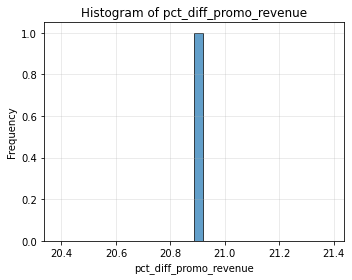

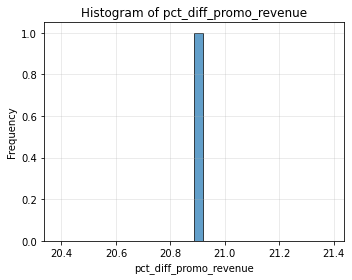

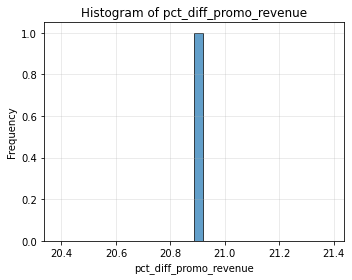

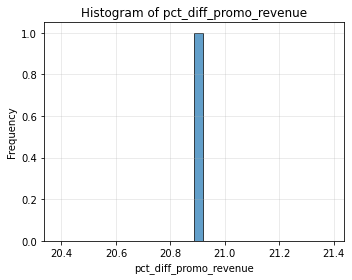

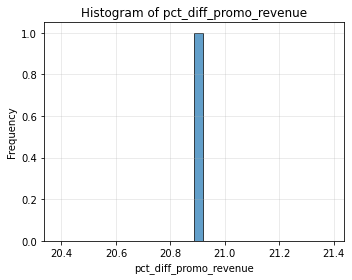

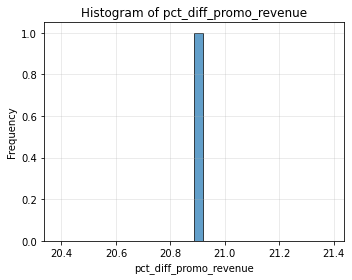

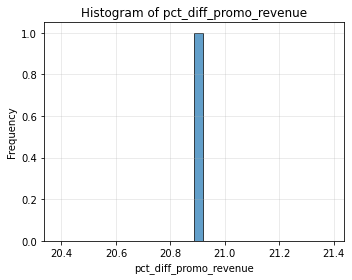

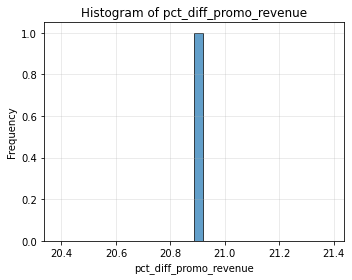

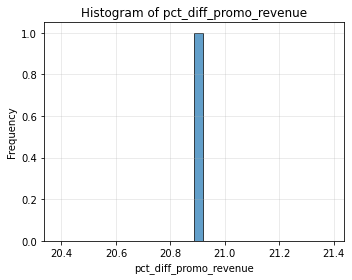

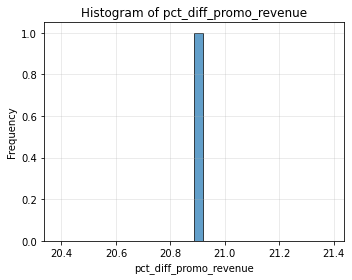

In [676]:
for query_ind in [14]:
    for mi in [1/128, 1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1.0, 2.0, 4.0]:
        null_info = {}
        orig = pl.read_csv(f'unnoised/q{query_ind}.csv')
        if query_ind == 22:
            orig = orig.select(
            pl.col("cntrycode").cast(str),
            pl.col("numcust"),
            pl.col("totacctbal"))
        noised = pl.read_json(f'outputs/ap-duckdb-q{query_ind}-customer--0.0078125--step3/output.json')
        if index_cols[query_ind]:
            merged_df = orig.join(noised, on=index_cols[query_ind], suffix='_noised')
        else:
            merged_df = orig.join(noised, suffix='_noised', how='cross')
        suffix1 = ''
        suffix2 = '_noised'
        cols_with_suffixes = [col for col in merged_df.columns if suffix1 in col or suffix2 in col]

        base_names = set([col.replace(suffix1, '').replace(suffix2, '') for col in cols_with_suffixes])
        for base_name in base_names:
            nulls_exist = False
            null_inds, null_vals = [], []

            orig = base_name + suffix1
            noised = base_name + suffix2
            if orig in merged_df.columns and noised in merged_df.columns:
                rel_errors = []
                for ind in range(len(merged_df[orig])):
                    if query_ind in scale_required:
                        const = 2 # subsampling scaling
                    else:
                        const = 1
    #                     print(merged_df[noised][ind])
                    new = np.average(
                        [100*abs(
                            const*merged_df[noised][ind][tmp_ind] - merged_df[orig][ind]
                            ) / merged_df[orig][ind] for tmp_ind in range(
                                len(merged_df[noised][ind]))]
                    )
                    rel_errors.append(new)
                merged_df = merged_df.with_columns(pl.Series('pct_diff_' + base_name, rel_errors))
                num_outputs = len(list(merged_df[noised]))
                for ind in range(num_outputs):
                    full_list = [x for x in list(merged_df[noised][ind]) if x is not None]
                    if len(full_list) < 100:
                        nulls_exist = True
                        null_inds.append(ind)
                        null_vals.append((100-len(full_list)))
                        print(query_ind, ind)
            null_info[base_name] = (nulls_exist, null_inds, null_vals)

        # Get columns that start with 'pct_diff'
        pct_diff_cols = [col for col in merged_df.columns if col.startswith('pct_diff')]

        # Create subplots based on number of pct_diff columns
        n_cols = len(pct_diff_cols)
        fig, axes = plt.subplots(1, n_cols, figsize=(5*n_cols, 4))

        # Handle case where there's only one column (axes won't be a list)
        if n_cols == 1:
            axes = [axes]

        # Create histogram for each column
        for i, col in enumerate(pct_diff_cols):
            # Convert to pandas for easier plotting, or use polars plot method
            values = merged_df[col].to_pandas()

            axes[i].hist(values, bins=30, alpha=0.7, edgecolor='black')
            axes[i].set_title(f'Histogram of {col}')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Frequency')
            axes[i].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(f'figs/mi_1_2/q{query_ind}_{mi}_{col}_hist.png', facecolor='white', bbox_inches='tight')

        for base in null_info:
            (nulls_exist, null_inds, null_vals) = null_info[base]
            if nulls_exist:
                fig, axes = plt.subplots(1, 1, figsize=(5, 4))
                # Handle case where there's only one column (axes won't be a list)
                if n_cols == 1:
                    axes = [axes]
                axes[0].hist(null_vals, bins=30, alpha=0.7, edgecolor='black')
                axes[0].set_title(f'Histogram of nulls for column {base}')
                axes[0].set_xlabel('Fraction of nulls (%)')
                axes[0].set_ylabel('Frequency')
                axes[0].grid(True, alpha=0.3)
                plt.savefig(f'figs/q{query_ind}_{mi}_{base}_nulls.png', facecolor='white', bbox_inches='tight')

In [675]:
merged_df

l_shipmode,high_line_count,low_line_count,high_line_count_noised,low_line_count_noised,pct_diff_low_line_count,pct_diff_high_line_count
str,i64,i64,list[f64],list[f64],f64,f64
"""MAIL""",647,945,"[389.122225, 361.80827, … 345.259156]","[362.573914, 381.110733, … 395.749319]",24.775863,25.496231
"""SHIP""",620,943,"[309.529916, 364.242572, … 247.300053]","[303.025984, 435.035562, … 563.42366]",22.846729,27.122692


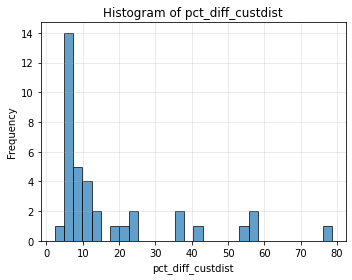

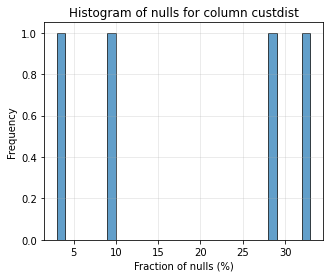